<a href="https://colab.research.google.com/github/AYEOOON/AI-project/blob/main/Mask_R_CNN_finetuning_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2023-10-03 14:15:01--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  72.7MB/s    in 0.7s    

2023-10-03 14:15:02 (72.7 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-10-03 14:15:02--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-10-03 14:15:02--
Total wall clock time: 1.0s
Downloaded: 1 files, 51M in 0.7s (72.7 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

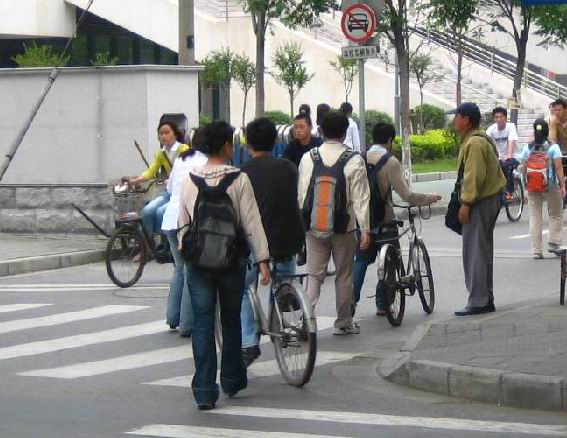

In [4]:
from PIL import Image
Image.open('/content/drive/MyDrive/PennFudanPed/PNGImages/FudanPed00046.png')

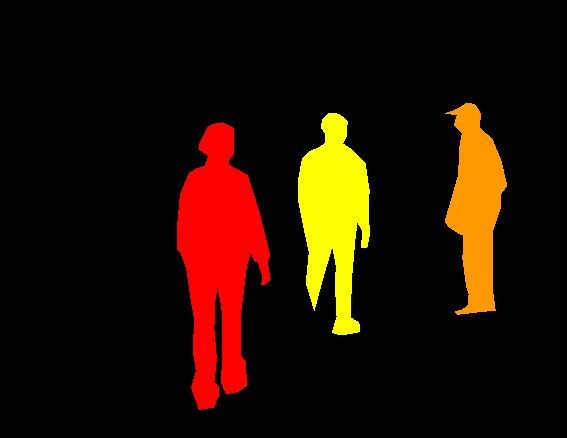

In [5]:
mask = Image.open('/content/drive/MyDrive/PennFudanPed/PedMasks/FudanPed00046_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask = mask.convert('P')  # 해결!
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

### PennFudan를 위한 사용자 정의 데이터셋 작성하기

In [6]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # 모든 이미지 파일들을 읽고, 정렬하여
        # 이미지와 분할 마스크 정렬을 확인합니다
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # 이미지와 마스크를 읽어옵니다
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # 분할 마스크는 RGB로 변환하지 않음을 유의하세요
        # 왜냐하면 각 색상은 다른 인스턴스에 해당하며, 0은 배경에 해당합니다
        mask = Image.open(mask_path)
        # numpy 배열을 PIL 이미지로 변환합니다
        mask = np.array(mask)
        # 인스턴스들은 다른 색들로 인코딩 되어 있습니다.
        obj_ids = np.unique(mask)
        # 첫번째 id 는 배경이라 제거합니다
        obj_ids = obj_ids[1:]

        # 컬러 인코딩된 마스크를 바이너리 마스크 세트로 나눕니다
        masks = mask == obj_ids[:, None, None]

        # 각 마스크의 바운딩 박스 좌표를 얻습니다
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # 모든 것을 torch.Tensor 타입으로 변환합니다
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # 객체 종류는 한 종류만 존재합니다(역자주: 예제에서는 사람만이 대상입니다)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # 모든 인스턴스는 군중(crowd) 상태가 아님을 가정합니다
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPedPennFudanPed/')
dataset[0]

TypeError: ignored

### 모델 정의하기

1 - 미리 학습된 모델로부터 미세 조정

In [17]:
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# # COCO로 미리 학습된 모델 읽기
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# # 분류기를 새로운 것으로 교체하는데, num_classes는 사용자가 정의합니다
# num_classes = 2  # 1 클래스(사람) + 배경
# # 분류기에서 사용할 입력 특징의 차원 정보를 얻습니다
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # 미리 학습된 모델의 머리 부분을 새로운 것으로 교체합니다
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

2 - 다른 백본을 추가하도록 모델을 수정하기

In [18]:
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# # 분류 목적으로 미리 학습된 모델을 로드하고 특징들만을 리턴하도록 합니다
# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # Faster RCNN은 백본의 출력 채널 수를 알아야 합니다.
# # mobilenetV2의 경우 1280이므로 여기에 추가해야 합니다.
# backbone.out_channels = 1280

# # RPN(Region Proposal Network)이 5개의 서로 다른 크기와 3개의 다른 측면 비율(Aspect ratio)을 가진
# # 5 x 3개의 앵커를 공간 위치마다 생성하도록 합니다.
# # 각 특징 맵이 잠재적으로 다른 사이즈와 측면 비율을 가질 수 있기 때문에 Tuple[Tuple[int]] 타입을 가지도록 합니다.

# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # 관심 영역의 자르기 및 재할당 후 자르기 크기를 수행하는 데 사용할 피쳐 맵을 정의합니다.
# # 만약 백본이 텐서를 리턴할때, featmap_names 는 [0] 이 될 것이라고 예상합니다.
# # 일반적으로 백본은 OrderedDict[Tensor] 타입을 리턴해야 합니다.
# # 그리고 특징맵에서 사용할 featmap_names 값을 정할 수 있습니다.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# # 조각들을 Faster RCNN 모델로 합칩니다.
# model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

### PennFudan 데이터셋을 위한 인스턴스 분할 모델

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # COCO 에서 미리 학습된 인스턴스 분할 모델을 읽어옵니다
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # 분류를 위한 입력 특징 차원을 얻습니다
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 미리 학습된 헤더를 새로운 것으로 바꿉니다
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 마스크 분류기를 위한 입력 특징들의 차원을 얻습니다
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # 마스크 예측기를 새로운 것으로 바꿉니다
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

### 모든 것을 하나로 합치기

In [20]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084d8 version check against PyTorch's CUDA version


In [21]:
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### 메인 함수

In [22]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)



In [23]:
# 학습을 GPU로 진행하되 GPU가 가용하지 않으면 CPU로 합니다
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 우리 데이터셋은 두 개의 클래스만 가집니다 - 배경과 사람
num_classes = 2
# 데이터셋과 정의된 변환들을 사용합니다
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# 데이터셋을 학습용과 테스트용으로 나눕니다(역자주: 여기서는 전체의 50개를 테스트에, 나머지를 학습에 사용합니다)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# 데이터 로더를 학습용과 검증용으로 정의합니다
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# 도움 함수를 이용해 모델을 가져옵니다
model = get_model_instance_segmentation(num_classes)

# 모델을 GPU나 CPU로 옮깁니다
model.to(device)

# 옵티마이저(Optimizer)를 만듭니다
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
# 학습률 스케쥴러를 만듭니다
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

In [24]:
from engine import train_one_epoch, evaluate
# 10 에포크만큼 학습해봅시다
num_epochs = 10

for epoch in range(num_epochs):
    # 1 에포크동안 학습하고, 10회 마다 출력합니다
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # 학습률을 업데이트 합니다
    lr_scheduler.step()
    # 테스트 데이터셋에서 평가를 합니다
    evaluate(model, data_loader_test, device=device)

print("That's it!")

ModuleNotFoundError: ignored

In [25]:
# pick one image from the test set
img, _ = dataset_test[15]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [26]:
prediction

[{'boxes': tensor([[  0.0000,  68.4319,  60.0197, 127.7879],
          [315.7298,  88.1601, 341.4713, 248.1681],
          [356.1119,  58.7353, 409.9940, 159.8996],
          [ 24.3302,  76.2907,  54.2418, 127.0394],
          [208.2063,  92.6494, 315.8036, 133.6524],
          [367.4814,  31.5069, 379.9506,  53.2039],
          [316.2302,  77.6357, 347.4156, 172.8067],
          [126.2182,  85.3203, 134.7747,  90.2463],
          [292.0608,  53.9165, 411.7417, 152.6172],
          [291.5111,  52.4256, 359.3955, 185.2419],
          [321.2879,  41.8298, 391.0631, 233.0371],
          [229.5036,  64.3385, 417.0000, 182.9295],
          [362.3258,  32.0992, 414.5467, 231.8870],
          [275.8244,  59.7588, 317.9845, 128.4424],
          [248.3235,  48.8440, 293.7217, 136.8904],
          [262.9470,  53.0041, 305.5819, 130.3167],
          [277.7997,  91.2317, 290.4012, 124.4985],
          [ 33.2577,  65.7505,  63.2240,  94.4087],
          [124.1644,  85.5147, 139.2197, 100.2951],
   

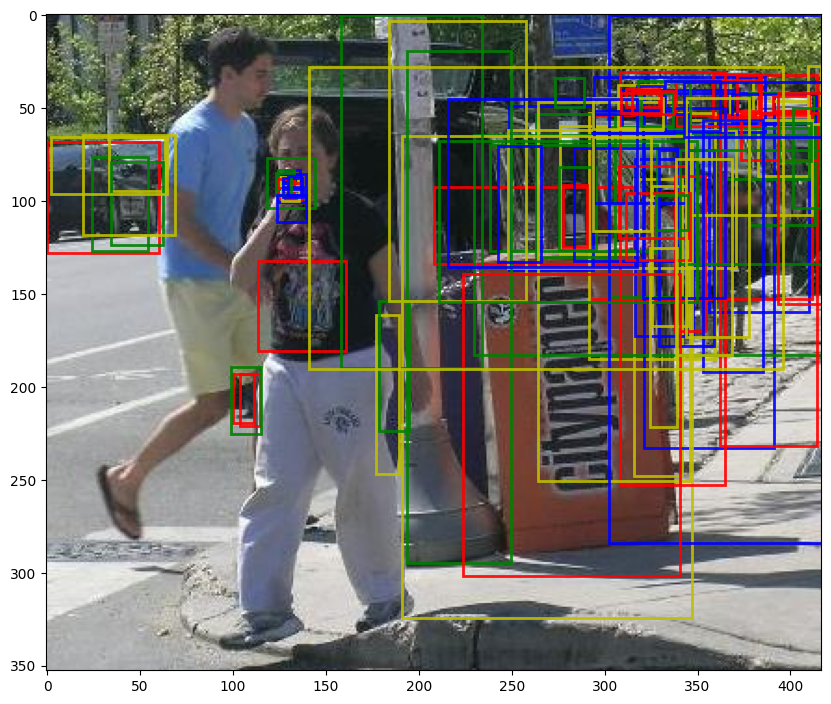

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def imshow(inp, pred):
    """Imshow for Tensor."""
    fig, ax = plt.subplots(1, figsize=(10, 10))
    inp = inp.numpy().transpose((1, 2, 0))
    for i in range(pred.shape[0]):
      color = ['r', 'y', 'b', 'g']
      width = prediction[0]["boxes"][i][2] - prediction[0]["boxes"][i][0]
      height = prediction[0]["boxes"][i][3] - prediction[0]["boxes"][i][1]
      rect = patches.Rectangle((prediction[0]["boxes"][i][0], prediction[0]["boxes"][i][1]), width, height, linewidth = 2, edgecolor = color[i%4], facecolor = 'none', alpha=0.9)
      ax.add_patch(rect)
    ax.imshow(inp)

imshow(torchvision.utils.make_grid(img), prediction[0]["boxes"])

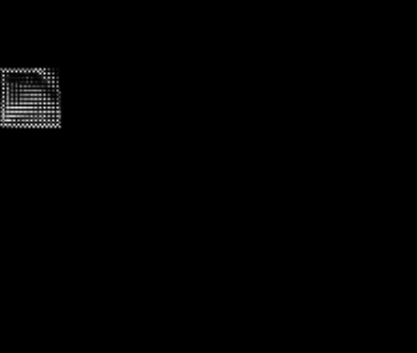

In [28]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

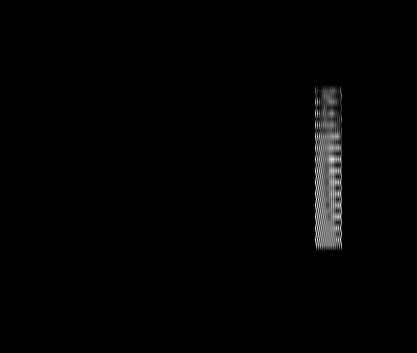

In [29]:
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())